In [26]:
import os
import numpy as np
from scipy.stats import ttest_ind
import mne

# -------------------------------
# Configuration
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"

# PD: first 50 subjects
GROUP_A = [f"sub-{i:03d}" for i in range(1, 51)]

# HC: subjects 100–149 but skip 121
GROUP_B = [f"sub-{i:03d}" for i in range(100, 150) if i != 121]

BAND = "alpha"

# Define the electrodes for Frontal-Occipital coupling
CH_1 = "Fz"
CH_2 = "Oz"

# -------------------------------
# Helper: get channel indices from epochs
# -------------------------------
def get_channel_indices(subj, ch1_name, ch2_name):
    epo_file = os.path.join(BASE_DIR, subj, f"epo_{subj[-3:]}_raw.fif")
    if not os.path.exists(epo_file):
        raise FileNotFoundError(f"{subj}: epochs file missing")
    
    # Load metadata only (faster)
    epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
    ch_names = [ch.upper() for ch in epochs.ch_names]

    try:
        idx1 = ch_names.index(ch1_name.upper())
        idx2 = ch_names.index(ch2_name.upper())
    except ValueError:
        raise ValueError(f"{subj}: {ch1_name} or {ch2_name} not found in channels")
    
    return idx1, idx2

# -------------------------------
# Load PLI values safely
# -------------------------------
def load_connectivity_values(subjects, band="alpha", ch1="Fz", ch2="Oz"):
    vals = []
    valid_subs = []

    for subj in subjects:
        path = os.path.join(BASE_DIR, subj, "data", f"{subj}_{band}_pli_matrix.npy")
        if not os.path.exists(path):
            print(f"{subj}: missing PLI file")
            continue

        mat = np.load(path)
        
        # Symmetrize triangular matrices
        if np.allclose(mat, np.tril(mat)) or np.allclose(mat, np.triu(mat)):
            mat = mat + mat.T

        try:
            idx1, idx2 = get_channel_indices(subj, ch1, ch2)
        except Exception as e:
            print(e)
            continue

        if idx1 >= mat.shape[0] or idx2 >= mat.shape[1]:
            print(f"{subj}: Channel indices out of range for {mat.shape[0]} channels")
            continue

        val = mat[idx1, idx2]
        if val == 0 and idx1 != idx2:
            val = mat[idx2, idx1]

        if not np.isfinite(val):
            print(f"{subj}: non-finite value")
            continue

        vals.append(val)
        valid_subs.append(subj)

    # Preview a few values
    print(f"\n{ch1}–{ch2} PLI preview ({band}):")
    if len(vals) > 0:
        for i, v in zip(valid_subs[:5], vals[:5]):
            print(f"  {i}: {v:.6f}")
    return np.array(vals, dtype=float)

# -------------------------------
# Extract values
# -------------------------------
print(f"Analyzing {CH_1} to {CH_2} connectivity...")
A = load_connectivity_values(GROUP_A, BAND, CH_1, CH_2)
B = load_connectivity_values(GROUP_B, BAND, CH_1, CH_2)

# -------------------------------
# Statistics & Results
# -------------------------------
print("\n--- Statistics ---")
if len(A) < 5 or len(B) < 5:
    print("Error: Not enough valid subjects for comparison.")
elif np.std(A) == 0 or np.std(B) == 0:
    print("Error: Zero variance detected. Check PLI matrices for empty data.")
else:
    t, p = ttest_ind(A, B, equal_var=False)
    print(f"{CH_1}–{CH_2} {BAND.capitalize()} PLI")
    print(f"PD (n={len(A)}) mean: {A.mean():.6f}")
    print(f"HC (n={len(B)}) mean: {B.mean():.6f}")
    print(f"t-statistic: {t:.3f}")
    print(f"p-value: {p:.6g}")

    if p < 0.05:
        print("Result: Statistically Significant")
    else:
        print("Result: Not Statistically Significant")


Analyzing Fz to Oz connectivity...


C:\Users\User\AppData\Local\Temp\ipykernel_37880\1000745796.py:32: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_37880\1000745796.py:32: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-002\epo_002_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_37880\1000745796.py:32: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-003\epo_003_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  


Fz–Oz PLI preview (alpha):
  sub-001: 0.224675
  sub-002: 0.066049
  sub-003: 0.091200
  sub-004: 0.081538
  sub-005: 0.076860


C:\Users\User\AppData\Local\Temp\ipykernel_37880\1000745796.py:32: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-100\epo_100_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_37880\1000745796.py:32: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-101\epo_101_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_37880\1000745796.py:32: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-102\epo_102_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  


Fz–Oz PLI preview (alpha):
  sub-100: 0.391176
  sub-101: 0.060902
  sub-102: 0.142308
  sub-103: 0.196581
  sub-104: 0.094393

--- Statistics ---
Fz–Oz Alpha PLI
PD (n=50) mean: 0.158366
HC (n=49) mean: 0.127840
t-statistic: 2.227
p-value: 0.0283463
Result: Statistically Significant


C:\Users\User\AppData\Local\Temp\ipykernel_37880\1000745796.py:32: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-143\epo_143_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_37880\1000745796.py:32: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-144\epo_144_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_37880\1000745796.py:32: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-145\epo_145_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  

In [ ]:
import numpy as np
import os

path = r"C:\Users\User\Documents\EEG_Project\rEEG\sub-001\data\sub-001_alpha_pli_matrix.npy"
x = np.load(path)

print("Shape:", x.shape)
print("Total elements:", x.size)
import numpy as np
path = r"C:\Users\User\Documents\EEG_Project\rEEG\sub-002\data\sub-002_alpha_pli_matrix.npy"
mat = np.load(path)
print("Shape:", mat.shape)
print("Min:", np.min(mat), "Max:", np.max(mat), "Mean:", np.mean(mat))



C:\Users\User\AppData\Local\Temp\ipykernel_37880\2996872666.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Group', y='PLI', data=data, palette='Set2', showfliers=False)


Plot saved as Fz_Oz_Alpha_Connectivity.png


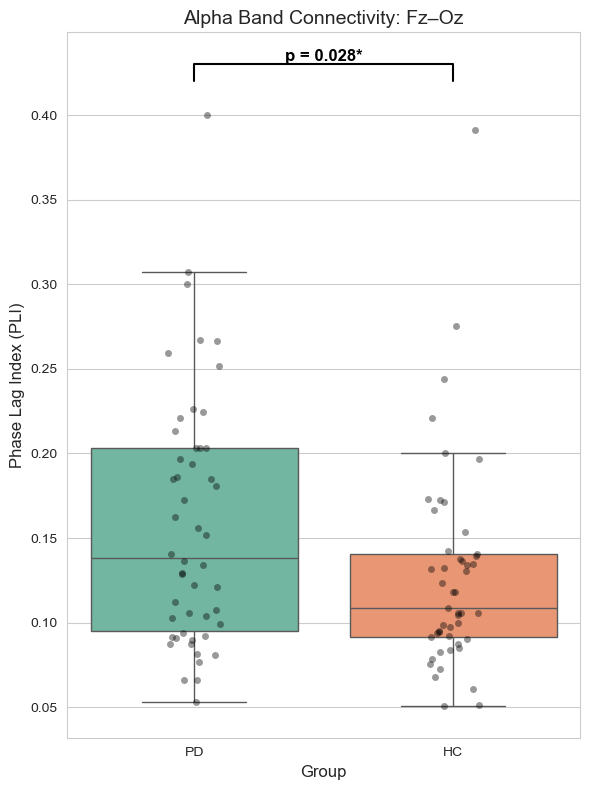

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Prepare data for plotting
data = pd.DataFrame({
    'PLI': np.concatenate([A, B]),
    'Group': ['PD'] * len(A) + ['HC'] * len(B)
})

# 2. Create the plot
plt.figure(figsize=(6, 8))
sns.set_style("whitegrid")

# Boxplot with individual points (stripplot)
ax = sns.boxplot(x='Group', y='PLI', data=data, palette='Set2', showfliers=False)
sns.stripplot(x='Group', y='PLI', data=data, color='black', alpha=0.4, jitter=True)

# Add significance annotation
x1, x2 = 0, 1
y, h, col = data['PLI'].max() + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "p = 0.028*", ha='center', va='bottom', color=col, fontsize=12, fontweight='bold')

plt.title(f'Alpha Band Connectivity: {CH_1}–{CH_2}', fontsize=14)
plt.ylabel('Phase Lag Index (PLI)', fontsize=12)
plt.xlabel('Group', fontsize=12)

# Save the figure
plt.tight_layout()
plt.savefig('Fz_Oz_Alpha_Connectivity.png', dpi=300)
print("Plot saved as Fz_Oz_Alpha_Connectivity.png")